<a href="https://colab.research.google.com/github/rpalakkal/Fabrik/blob/master/TiramisuBackgroundRemover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Removal with the Tiramisu Model

In this notebook we will be using a Tiramisu model implemented in Keras

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

TensorFlow 2.x selected.


In [0]:
dataset = tfds.load('caltech_birds2010')

In [0]:
imgSize = 64
def processData(dataset):
  x, y = [], []
  for datapoint in dataset:
    resizedImg = tf.image.resize(datapoint['image'], (imgSize, imgSize))
    normalizedImg = (tf.cast(resizedImg, tf.float32) / 255).numpy()
    x.append(normalizedImg)

    resizedMask = tf.image.resize(datapoint['segmentation_mask'], (imgSize, imgSize))
    normalizedMask = (resizedMask).numpy()
    y.append(normalizedMask)

  return np.array(x), np.array(y)

In [0]:
trainX, trainY = processData(dataset['train'])
testX, testY = processData(dataset['test'])

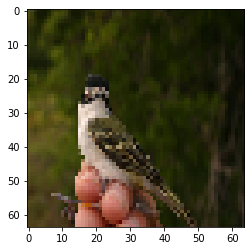

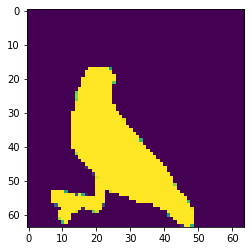

In [5]:
plt.imshow(trainX[0])
plt.show()
plt.imshow(trainY[0].reshape((64, 64)))
plt.show()

In [0]:
def removeBg(image, mask):
  img = np.copy(image)
  for idx in np.ndindex(mask.shape[:2]):
    if mask[idx] == 0:
      img[idx]=np.array([255, 255, 255])
  return img

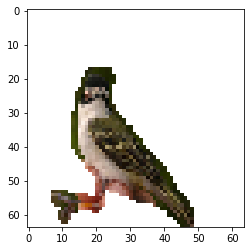

In [7]:
plt.imshow(removeBg(trainX[0],trainY[0]))
plt.show()

## Setting up the Tiramisu Model

In [0]:
def layer(x):
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  return x

In [0]:
def denseBlock(x, layers):
  outputBlock = []
  for i in range(layers-1):
    tmp = x
    x = layer(x)
    outputBlock.append(x)
    x = tf.keras.layers.concatenate([x, tmp])
  x = layer(x)
  outputBlock.append(x)
  outputBlock = tf.keras.layers.concatenate(outputBlock)
  return outputBlock

In [0]:
def transitionDown(x, filters):
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.MaxPool2D(padding='same')(x)
    return x

In [0]:
def transitionUp(x, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same')(x)
    return x

In [0]:
layers = [4, 5, 7, 10, 12]
nbFilters = [112, 192, 304, 464, 656, 1088, 816, 578, 384, 256]
skipConnections=[]

In [0]:
input = tf.keras.layers.Input((imgSize, imgSize, 3))
x = keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same')(input)

In [0]:
for i in range(5):
  x = denseBlock(x, layers[i])
  skipConnections.append(x)
  x = transitionDown(x, nbFilters[i])


In [0]:
x = denseBlock(x, 15)

In [0]:
skipConnections = skipConnections[::-1]
layers = layers[::-1]
nbFilters = nbFilters[5:]

In [0]:
for i in range(5):
  x = transitionUp(x, nbFilters[i])
  x = tf.keras.layers.concatenate([x, skipConnections[i]])
  x = denseBlock(x, layers[i])

In [0]:
x = tf.keras.layers.Conv2D(3, kernel_size=(1, 1), activation='softmax')(x)
model = tf.keras.models.Model(inputs=input, outputs=x)

## Training the Model

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=30, batch_size=64, shuffle=True)

Train on 3000 samples, validate on 3033 samples
Epoch 1/30
3000/3000 [==============================] - 50s 17ms/sample - loss: 0.4783 - accuracy: 0.8073 - val_loss: 0.4940 - val_accuracy: 0.8373
Epoch 2/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.3328 - accuracy: 0.8449 - val_loss: 0.3786 - val_accuracy: 0.8395
Epoch 3/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2791 - accuracy: 0.8771 - val_loss: 0.3713 - val_accuracy: 0.8377
Epoch 4/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2637 - accuracy: 0.8846 - val_loss: 0.3509 - val_accuracy: 0.8401
Epoch 5/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2474 - accuracy: 0.8933 - val_loss: 0.4999 - val_accuracy: 0.8377
Epoch 6/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2391 - accuracy: 0.8955 - val_loss: 0.4125 - val_accuracy: 0.8410
Epoch 7/30
3000/3000 [==============================] - 25s 8ms/sampl

## Testing out Background Removal

In [0]:
def predict(i):
  i = tf.image.resize(i, (64, 64))
  prediction = model.predict(tf.reshape(i, (1,64,64,3)))
  prediction = np.argmax(prediction, axis=-1)[0]
  return prediction

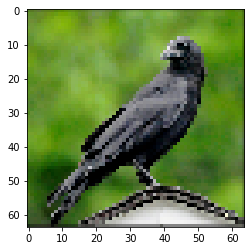

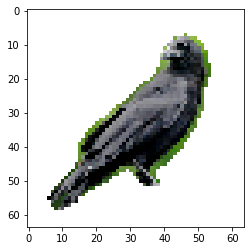

In [22]:
plt.imshow(testX[100])
plt.show()

mask = predict(testX[100])
plt.imshow(removeBg(testX[100],mask))
plt.show()